<div class='alert alert-success'>
    <h1 align="center"> Handwritten digit dataset in Farsi & English</h1> 
     <h1 align="center">   Image classification </h1>
</div>

# Handwritten English digit

Recognition of handwritten characters is one of the most interesting topics in pattern recognition domain. For some scripts such as English, there are standard datasets available, well-known one is called MNIST. The MNIST, modified NIST, 5 dataset (LeCun et al.,1995) was extracted from the NIST datasets SD3 and SD7. Samples are normalized into 20 * 20 gray-scale images with aspect ratio reserved, and the normalized images are located in a 28 * 28 frame. The dataset is available from LeCun. Number of training and test samples are 60,000 and 10,000 respectively.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 1

import warnings
import gzip, pickle
import numpy as np
import matplotlib.pyplot as plt

from utils import *
from plot_utils import *

warnings.filterwarnings(action='ignore')

In [2]:
# matplotlib configuration
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['image.interpolation'] = 'spline16'

# numpy setup
np.set_printoptions(precision=2)
np.random.seed(0)

MNIST: a dataset of handwritten digits, each digit is an image of size 28-by-28 pixels.


- 50000 training data
- 10000 validation data
- 10000 test data

In [3]:
DATA_PATH = 'dataset/mnist.pkl.gz'

with gzip.open(DATA_PATH, 'rb') as f:
    (X_train, y_train), (X_valid, y_valid), (X_test,  y_test) = pickle.load(f, encoding='latin1')

# As a sanity check, we print out the size of the data.
print('Training data shape:    ', X_train.shape)
print('Training labels shape:  ', y_train.shape)
print('Validation data shape:  ', X_valid.shape)
print('Validation labels shape:', y_valid.shape)
print('Test data shape:        ', X_test.shape)
print('Test labels shape:      ', y_test.shape)

Training data shape:     (50000, 784)
Training labels shape:   (50000,)
Validation data shape:   (10000, 784)
Validation labels shape: (10000,)
Test data shape:         (10000, 784)
Test labels shape:       (10000,)


In [4]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
classes[6]

'6'

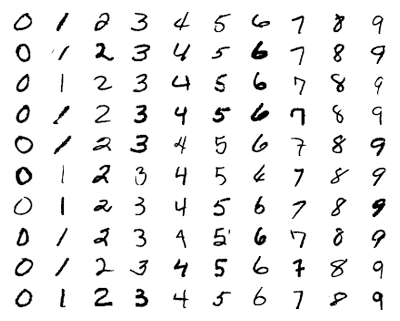

In [5]:
plot_random_samples(X_train, y_train, classes, samples_per_class=10)
# print 10 sample per class

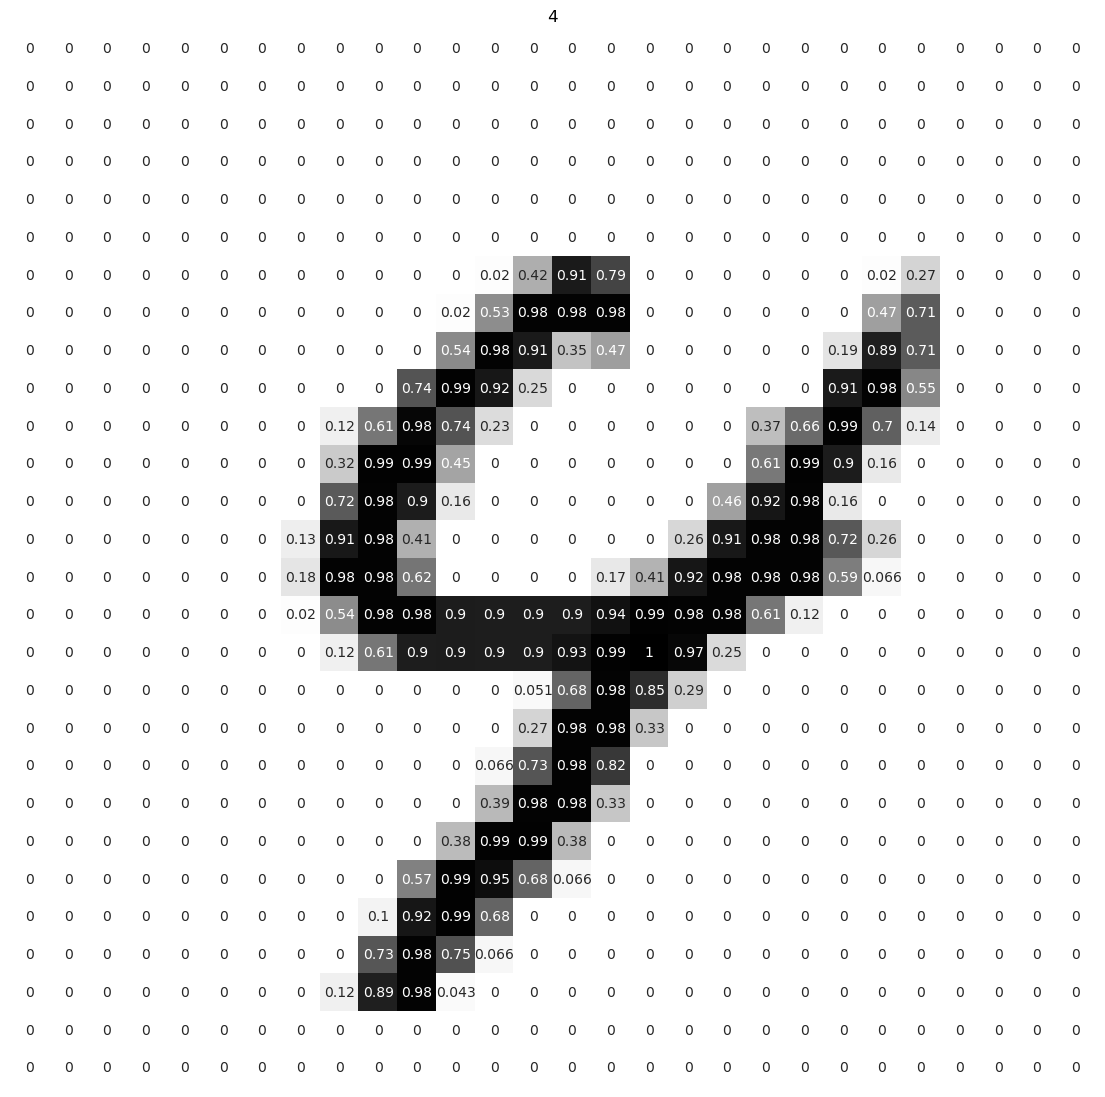

In [6]:
plot_sample(X_train, y_train, annot=True, idx=None)

## Preprocessing: normalization

- In this dataset, every pixel has a value in `[0, 1]`, so there is no need for feature scaling.
- But still we need to subtract the mean. 

Note that the mean vector is computed only from training data and subtracted from all data.

In [7]:
# compute mean vector from training data
mu = np.mean(X_train, axis=0)

# remove mean vector from all data
X_train -= mu
X_valid -= mu
X_test  -= mu

In [8]:
mu.shape

(784,)

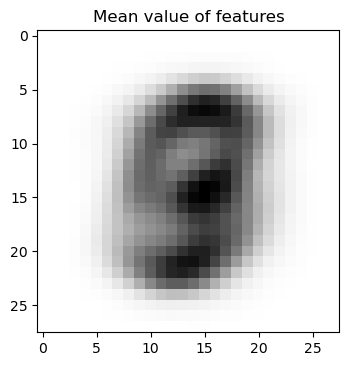

In [9]:
plt.figure(figsize=(4, 4))
plt.imshow(mu.reshape(28, 28), interpolation='nearest', cmap=plt.cm.Greys)
#plt.xticks([])
#plt.yticks([])
plt.title("Mean value of features")
plt.show()

**Prediction**

In [10]:
def predict(W, b, X):
    scores = X @ W + b
    return np.argmax(scores, axis=1)

In [11]:
c = 10                # number of classes 
n = X_train.shape[1]  # number of features

# init parameters randomly
W = 0.01 * np.random.randn(n, c)   # RANDOM value you may get
b = np.zeros(c)

# predict classes and compute accuracy
y_pred = predict(W, b, X_train)
acc = accuracy(y_pred, y_train)  # this function is defined in utils.py
print("Accuracy = {:.2f}%".format(acc))

Accuracy = 12.18%


### Mini-Batch Gradient Descent

In [12]:
def softmax_loss(W, b, X_batch, y_batch, mode='train'):
    bs = X_batch.shape[0]  # batch size
    
    scores = X_batch @ W + b
    probs = softmax(scores)
    loss = -np.sum(np.log(probs[range(bs), y_batch])) / bs
    
    if mode == 'test':
        return loss
    
    # compute gradients w.r.t scores
    dscores = np.copy(probs)
    dscores[range(bs), y_batch] -= 1.0
    dscores /= bs
    
    # compute gradients w.r.t W and b
    db = dscores.sum(axis=0)
    dW = X_batch.T @ dscores
    
    return loss, dW, db

In [13]:
def mini_batch_gradient_descent(X_train, y_train, X_valid, y_valid, batch_size=32, 
                                alpha=0.01, lmbda=1e-4, num_epochs=100):
    
    m, n = X_train.shape
    num_batches = m % batch_size
    
    report = "Epoch {:3d}: training loss = {:.2f} | validation loss = {:.2f}"
    
    # init parameters randomly
    W = np.random.randn(n, 10) * 0.001
    b = np.zeros((10,))
    
    for epoch in range(num_epochs):
        train_loss = 0.
        
        for batch in range(num_batches):
            
            # select a random mini-batch
            idx = np.random.choice(m, batch_size, replace=False)
            X_batch, y_batch = X_train[idx], y_train[idx]
            
            # compute loss and gradient
            loss, dW, db = softmax_loss(W, b, X_batch, y_batch)  # data loss
            loss += 0.5 * lmbda * np.sum(W ** 2)                 # regularization loss
            dW += lmbda * W
            
            train_loss += loss
            
            # update parameters            
            b = b - alpha * db
            W = W - alpha * dW
        
        # report stats after each epoch
        train_loss /= num_batches        
        valid_loss = softmax_loss(W, b, X_valid, y_valid, mode='test')
        print(report.format(epoch+1, train_loss, valid_loss))
    
    return W, b

In [14]:
# hyper-parameters
alpha = 1e-2
lmbda = 1e-4
batch_size = 128
num_epochs = 100

# run mini-batch gradient descent
W, b = mini_batch_gradient_descent(X_train, y_train, X_valid, y_valid, 
                                   batch_size=batch_size, alpha=alpha,
                                   lmbda=lmbda, num_epochs=num_epochs)

Epoch   1: training loss = 1.94 | validation loss = 1.63
Epoch   2: training loss = 1.45 | validation loss = 1.27
Epoch   3: training loss = 1.18 | validation loss = 1.06
Epoch   4: training loss = 1.04 | validation loss = 0.93
Epoch   5: training loss = 0.92 | validation loss = 0.84
Epoch   6: training loss = 0.86 | validation loss = 0.77
Epoch   7: training loss = 0.80 | validation loss = 0.72
Epoch   8: training loss = 0.74 | validation loss = 0.68
Epoch   9: training loss = 0.71 | validation loss = 0.65
Epoch  10: training loss = 0.68 | validation loss = 0.62
Epoch  11: training loss = 0.67 | validation loss = 0.60
Epoch  12: training loss = 0.65 | validation loss = 0.58
Epoch  13: training loss = 0.61 | validation loss = 0.56
Epoch  14: training loss = 0.60 | validation loss = 0.55
Epoch  15: training loss = 0.58 | validation loss = 0.53
Epoch  16: training loss = 0.57 | validation loss = 0.52
Epoch  17: training loss = 0.56 | validation loss = 0.51
Epoch  18: training loss = 0.54

In [15]:
train_acc = accuracy(predict(W, b, X_train), y_train)
valid_acc = accuracy(predict(W, b, X_valid), y_valid)

print('Training accuracy =   {:.2f}%'.format(train_acc))
print('Validation accuracy = {:.2f}%'.format(valid_acc))

Training accuracy =   89.71%
Validation accuracy = 90.97%


In [16]:
test_acc = accuracy(predict(W, b, X_test), y_test)
print('Test accuracy =   {:.2f}%'.format(train_acc))

Test accuracy =   89.71%


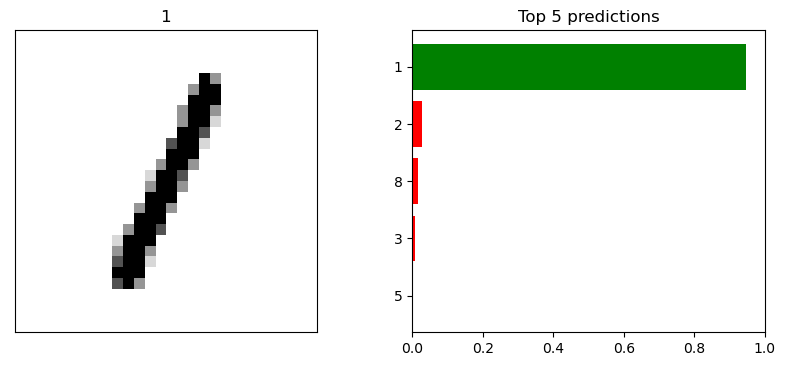

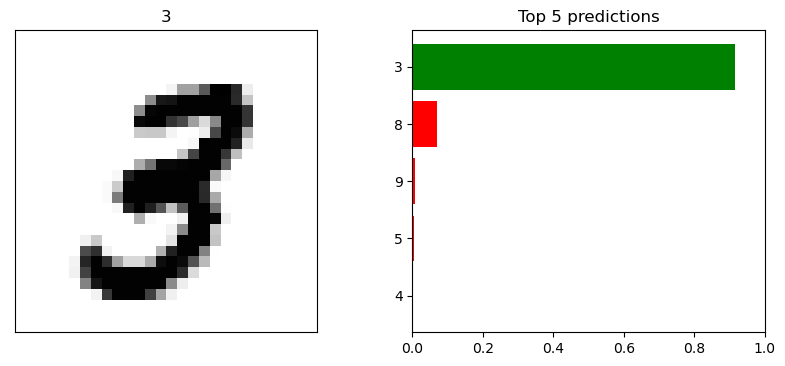

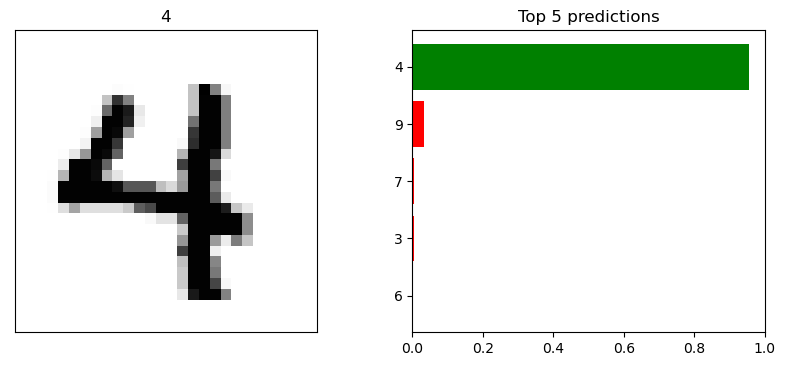

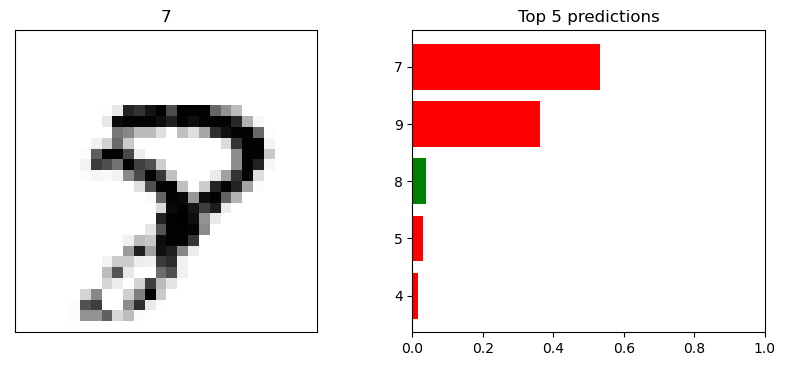

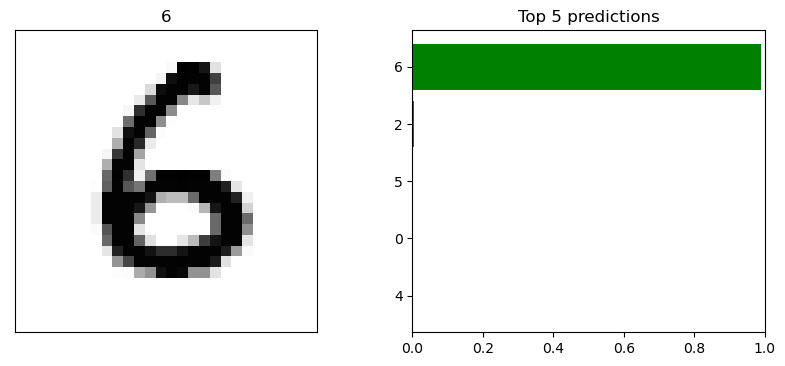

In [17]:
for _ in range(5):
    idx = np.random.choice(X_test.shape[0])
    probs = softmax(X_test[idx].reshape((1, -1)) @ W + b)[0]
    predict_and_plot(probs, X_test[idx], y_test[idx], mu, classes)

### Visualizing weights matrix

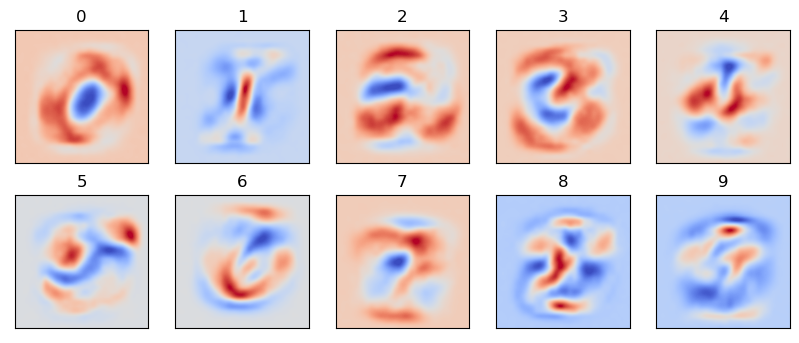

In [18]:
plt.figure(figsize=(10, 4))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(W[:, i].reshape((28, 28)), cmap=plt.cm.coolwarm)
    plt.xticks([])
    plt.yticks([])
    plt.title("%d" % i)
plt.show()

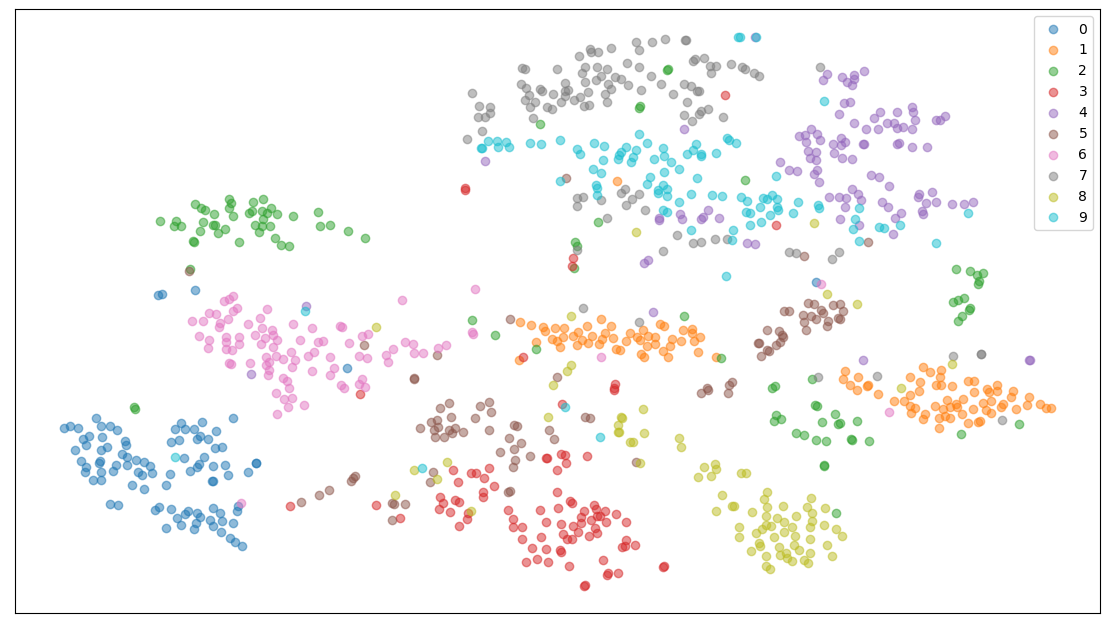

In [19]:
plot_tsne(X_train[:1000], y_train[:1000])

In [20]:
from utils import softmax_loss


class TwoLayerNeuralNetwork:
    
    def __init__(self, num_features=784, num_hiddens=20, num_classes=10):
        self.num_hiddens = num_hiddens
        self.num_classes = num_classes
        
        # random initialization: create random weights, set all biases to zero
        self.params = {}
        self.params['W1'] = np.random.randn(num_features, num_hiddens) * 0.001
        self.params['W2'] = np.random.randn(num_hiddens,  num_classes) * 0.001
        self.params['b1'] = np.zeros((num_hiddens,))
        self.params['b2'] = np.zeros((num_classes,))
        
    def forward(self, X):
        # forward step
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        
        # forward step
        h_in = X @ W1 + b1       # hidden layer input
        h = np.maximum(0, h_in)  # hidden layer output (using ReLU)
        scores = h @ W2 + b2     # neural net output
        
        return scores
                            
    def train_step(self, X, y):
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        
        # forward step
        h_in = X @ W1 + b1       # hidden layer input
        h = np.maximum(0, h_in)  # hidden layer output (using ReLU)
        scores = h @ W2 + b2     # neural net output
        
        # compute loss
        loss, dscores = softmax_loss(scores, y)
        
        # backward step
        db2 = dscores.sum(axis=0)
        dW2 = h.T @ dscores
        
        dh = dscores @ W2.T
        dh[h_in < 0] = 0.0
        db1 = dh.sum(axis=0)
        dW1 = X.T @ dh
        
        gradient = {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2}
                
        return loss, gradient
        
    def train(self, X_train, y_train, X_valid, y_valid, batch_size=50, 
              alpha=0.001, lmbda=0.0001, num_epochs=10):
        
        m, n = X_train.shape        
        num_batches = m // batch_size
        
        report = "{:3d}: training loss = {:.2f} | validation loss = {:.2f}"
        
        losses = []
        for epoch in range(num_epochs):
            train_loss = 0.0
            
            for _ in range(num_batches):
                W1, b1 = self.params['W1'], self.params['b1']
                W2, b2 = self.params['W2'], self.params['b2']
                
                # select a random mini-batch
                batch_idx = np.random.choice(m, batch_size, replace=False)
                X_batch, y_batch = X_train[batch_idx], y_train[batch_idx]

                # train on mini-batch
                data_loss, gradient = self.train_step(X_batch, y_batch)
                reg_loss = 0.5 * (np.sum(W1 ** 2) + np.sum(W2 ** 2))
                train_loss += (data_loss + lmbda * reg_loss)
                losses.append(data_loss + lmbda * reg_loss)

                # regularization
                gradient['W1'] += lmbda * W1
                gradient['W2'] += lmbda * W2

                # update parameters
                for p in self.params:
                    self.params[p] = self.params[p] - alpha * gradient[p]
            
            # report training loss and validation loss
            train_loss /= num_batches
            valid_loss = softmax_loss(self.forward(X_valid), y_valid, mode='test')
            print(report.format(epoch + 1, train_loss, valid_loss))
        
        return losses
    
    def predict(self, X):
        """ Predict labels for input data.
        """
        scores = self.forward(X)
        return np.argmax(scores, axis=1)
    
    def predict_proba(self, X):
        """ Predict probabilties of classes for each input data.
        """
        scores = self.forward(X)
        return softmax(scores)

In [21]:
mlp = TwoLayerNeuralNetwork(num_hiddens=20)
losses = mlp.train(X_train, y_train, X_valid, y_valid, 
                   alpha=0.05, lmbda=0.001, num_epochs=20)

  1: training loss = 1.30 | validation loss = 0.39
  2: training loss = 0.37 | validation loss = 0.29
  3: training loss = 0.32 | validation loss = 0.26
  4: training loss = 0.30 | validation loss = 0.24
  5: training loss = 0.27 | validation loss = 0.22
  6: training loss = 0.27 | validation loss = 0.21
  7: training loss = 0.25 | validation loss = 0.20
  8: training loss = 0.25 | validation loss = 0.19
  9: training loss = 0.24 | validation loss = 0.19
 10: training loss = 0.23 | validation loss = 0.18
 11: training loss = 0.23 | validation loss = 0.18
 12: training loss = 0.22 | validation loss = 0.17
 13: training loss = 0.22 | validation loss = 0.17
 14: training loss = 0.22 | validation loss = 0.17
 15: training loss = 0.22 | validation loss = 0.16
 16: training loss = 0.21 | validation loss = 0.16
 17: training loss = 0.21 | validation loss = 0.16
 18: training loss = 0.21 | validation loss = 0.15
 19: training loss = 0.20 | validation loss = 0.15
 20: training loss = 0.20 | val

In [22]:
train_acc = accuracy(mlp.predict(X_train), y_train)
print("Training accuracy   = {:.2f}%".format(train_acc))

test_acc = accuracy(mlp.predict(X_test), y_test)
print("Validation accuracy = {:.2f}%".format(test_acc))

Training accuracy   = 96.24%
Validation accuracy = 95.82%


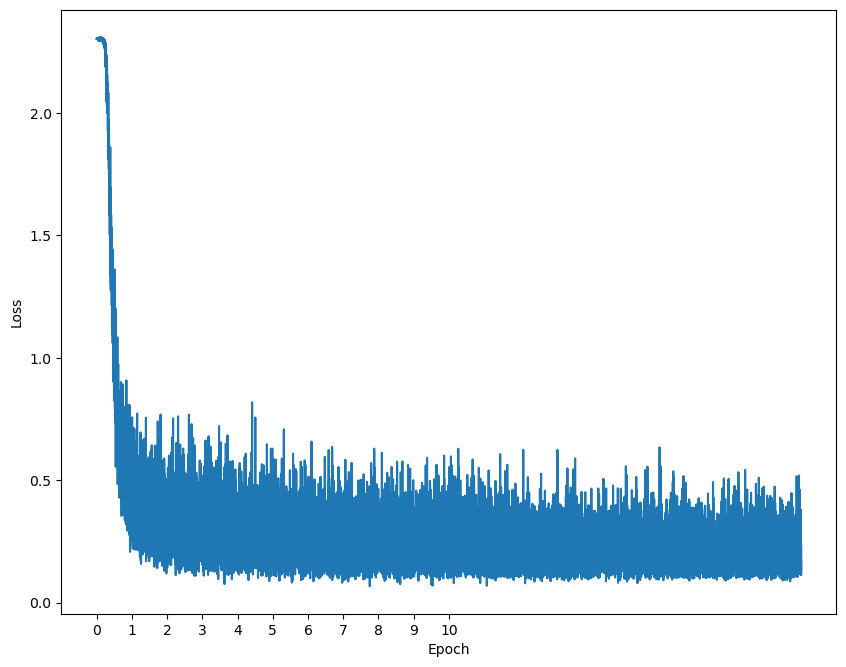

In [23]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(0, 10001, 1000), range(0, 11))
plt.show()

In [24]:
# Prediction for dataset
test_acc = accuracy(predict(W, b, X_test), y_test)
print('Test accuracy = {:.2f}%'.format(train_acc))

Test accuracy = 96.24%


## Plot misclassified data

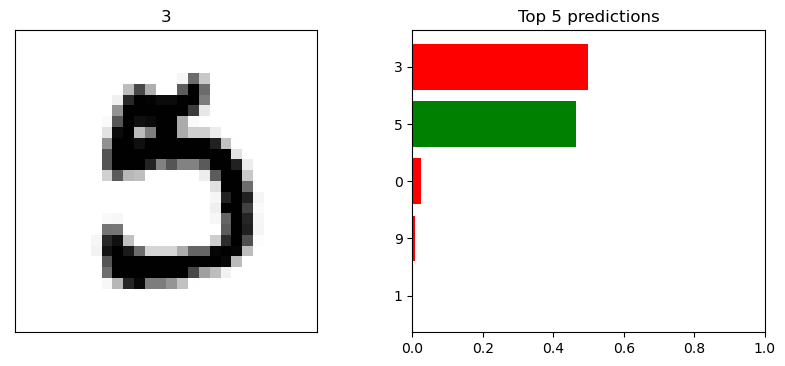

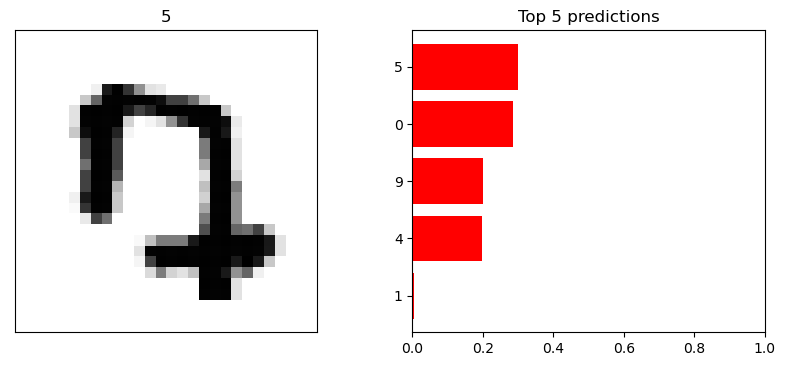

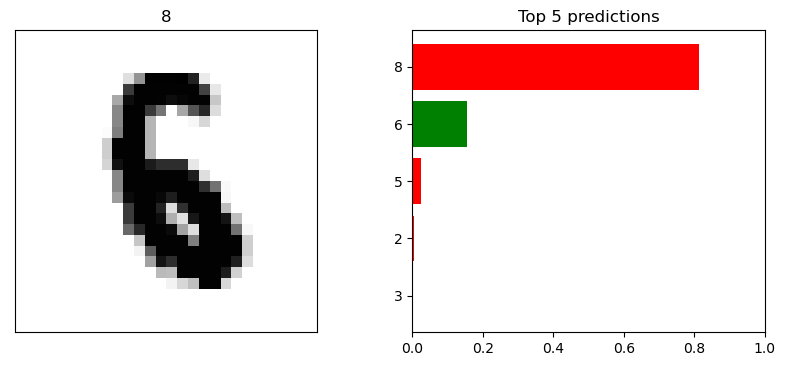

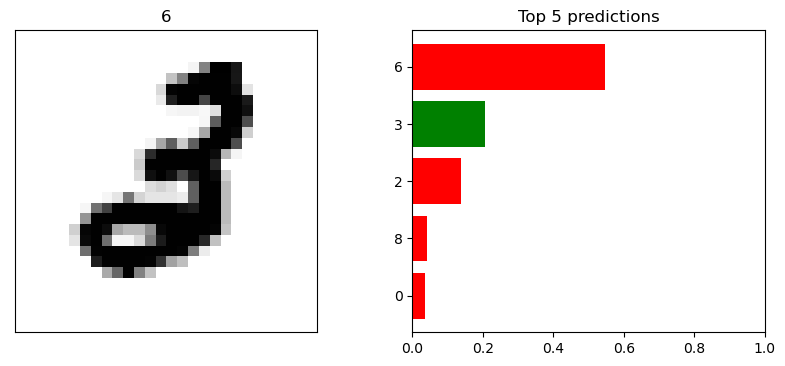

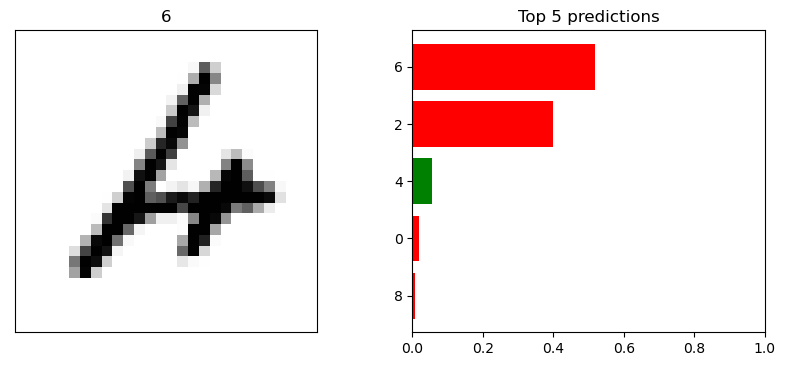

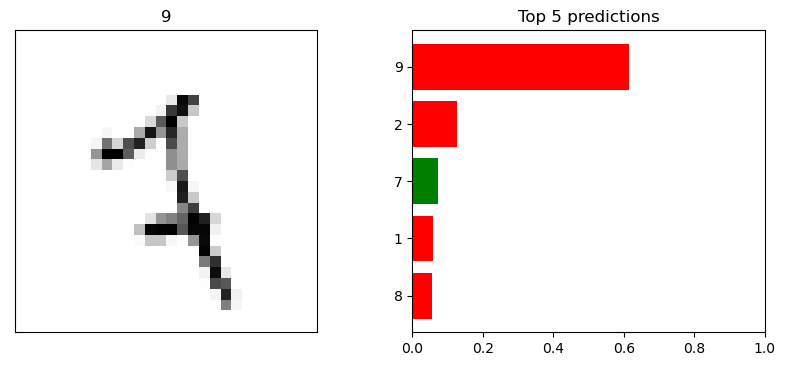

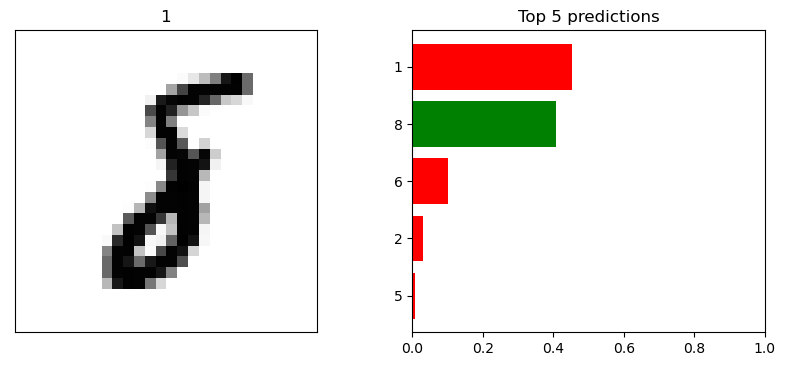

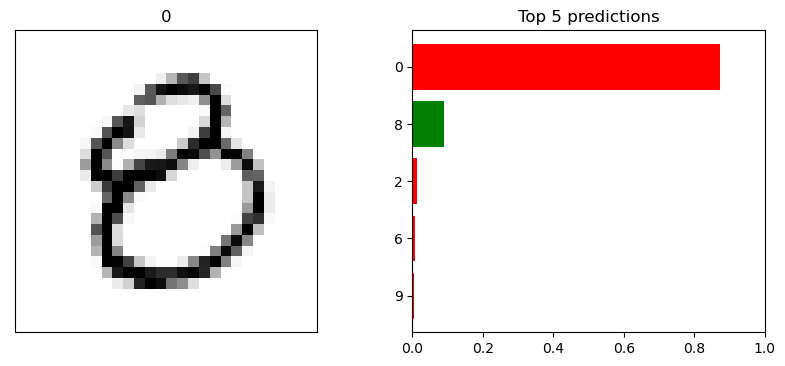

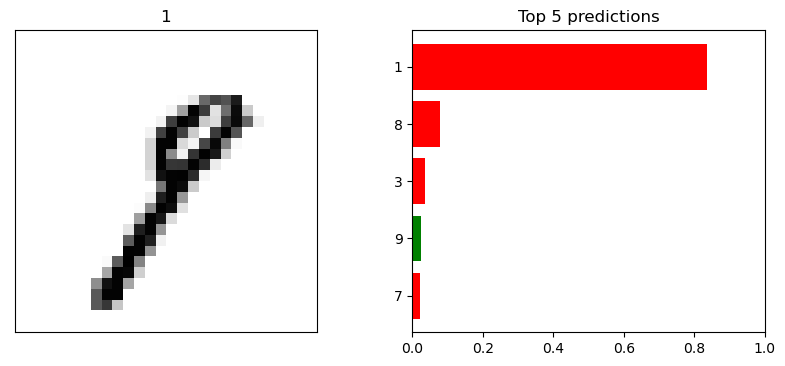

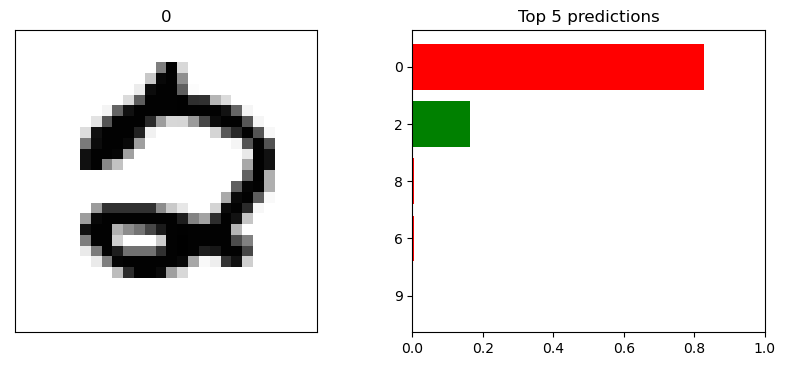

In [25]:
count = 10
y_pred = mlp.predict(X_test)
idx = np.flatnonzero(y_pred != y_test)
sample_idx = np.random.choice(idx, count)

for i in sample_idx:
    probs = mlp.predict_proba(X_test[i].reshape((1, -1)))[0]
    predict_and_plot(probs, X_test[i], y_test[i], mu, classes)

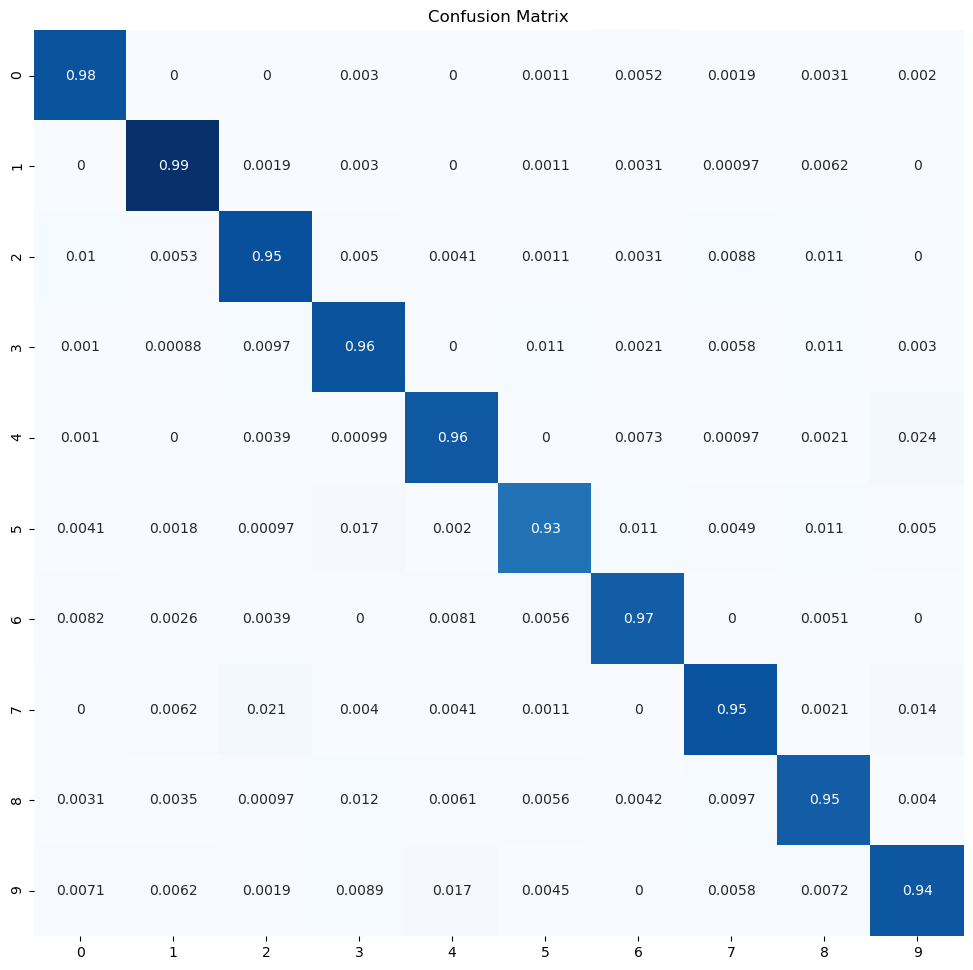

In [26]:
y_pred = mlp.predict(X_test)
plot_confusion_matrix(y_test, y_pred, normalize=True)

In [27]:
W = mlp.params['W1']
print(W.shape)

(784, 20)


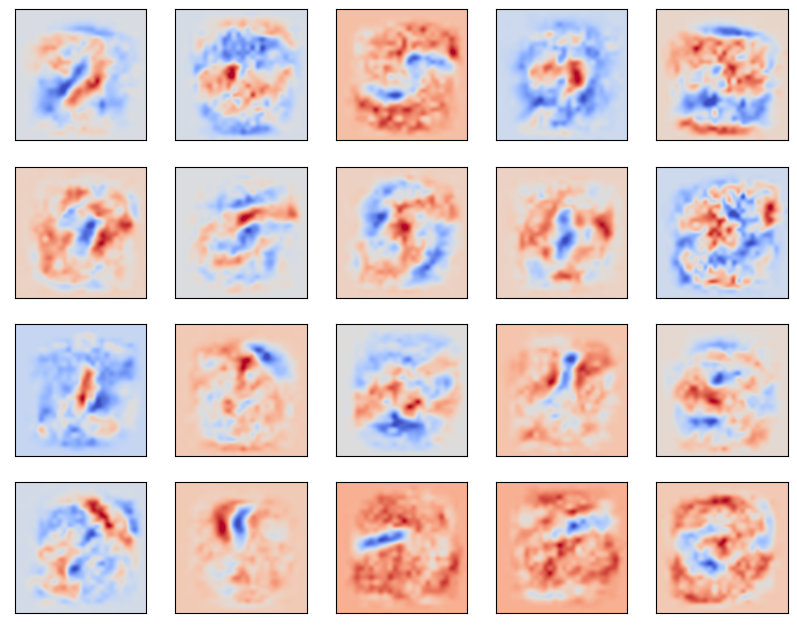

In [28]:
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(W[:, i].reshape((28, 28)), cmap=plt.cm.coolwarm)
    plt.xticks([])
    plt.yticks([])
plt.show()